In [21]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    confusion_matrix,
    classification_report
)

import warnings
warnings.filterwarnings('ignore')

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

DATA_DIR = Path('./data')
ADL_DIR = DATA_DIR / 'adl'
FALL_DIR = DATA_DIR / 'fall'
IMG_SIZE = 224
BATCH_SIZE = 8
NUM_FRAMES = 40
LEARNING_RATE = 1e-4
EPOCHS = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [22]:
def explore_sequences(base_dir, label_name):
    sequences = []
    
    for sequence_dir in sorted(base_dir.iterdir()):
        if sequence_dir.is_dir():
            frames = sorted(list(sequence_dir.glob('*.png')))
            
            if len(frames) > 0:
                sequences.append({
                    'sequence_name': sequence_dir.name,
                    'path': sequence_dir,
                    'num_frames': len(frames),
                    'label': label_name
                })
    
    return sequences

fall_sequences = explore_sequences(FALL_DIR, 'fall')
adl_sequences = explore_sequences(ADL_DIR, 'adl')

In [23]:
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [24]:
class FallDetectionDataset(Dataset):
    def __init__(self, sequences, num_frames=40, transform=None):
        self.sequences = sequences
        self.num_frames = num_frames
        self.transform = transform
        self.label_map = {'fall': 1, 'adl': 0}

    def __len__(self):
        return len(self.sequences)
    
    def _sample_frames(self, frame_paths):
        total_frames = len(frame_paths)
        
        if total_frames <= self.num_frames:
            indices = list(range(total_frames))
            indices += [total_frames - 1] * (self.num_frames - total_frames)
        else:
            indices = np.linspace(0, total_frames - 1, self.num_frames, dtype=int)
        
        return [frame_paths[i] for i in indices]

    def __getitem__(self, idx):
        seq_info = self.sequences[idx]
        all_frames = sorted(list(seq_info['path'].glob('*.png')))
        sampled_frames = self._sample_frames(all_frames)
        
        frames_tensors = []
        for frame_path in sampled_frames:
            img = Image.open(frame_path).convert('RGB')
            
            if self.transform:
                img = self.transform(img)
            
            frames_tensors.append(img)
        
        frames = torch.stack(frames_tensors)
        label = self.label_map[seq_info['label']]
        
        return frames, label

In [25]:
from sklearn.model_selection import train_test_split

all_sequences = fall_sequences + adl_sequences

train_val_sequences, test_sequences = train_test_split(
    all_sequences,
    test_size=0.2,
    random_state=SEED,
    stratify=[seq['label'] for seq in all_sequences]
)

train_sequences, val_sequences = train_test_split(
    train_val_sequences,
    test_size=0.125,
    random_state=SEED,
    stratify=[seq['label'] for seq in train_val_sequences]
)

train_dataset = FallDetectionDataset(
    train_sequences, 
    num_frames=NUM_FRAMES, 
    transform=train_transform  
)

val_dataset = FallDetectionDataset(
    val_sequences, 
    num_frames=NUM_FRAMES, 
    transform=test_transform  
)

test_dataset = FallDetectionDataset(
    test_sequences, 
    num_frames=NUM_FRAMES, 
    transform=test_transform 
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

In [26]:
import torch.nn as nn
from torchvision import models

class FallDetectionModel(nn.Module):
    def __init__(self, num_classes=2, lstm_hidden=256, lstm_layers=2, dropout=0.5):
        super(FallDetectionModel, self).__init__()
        
        resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-1])
        
        for param in self.feature_extractor.parameters():
            param.requires_grad = False
        
        self.feature_dim = 2048
        
        self.lstm = nn.LSTM(
            input_size=self.feature_dim,
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,
            dropout=dropout if lstm_layers > 1 else 0
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(lstm_hidden, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        batch_size, num_frames, c, h, w = x.shape
        
        x = x.view(batch_size * num_frames, c, h, w)
        x = self.feature_extractor(x)
        x = x.squeeze(-1).squeeze(-1)
        x = x.view(batch_size, num_frames, self.feature_dim)
        
        lstm_out, (h_n, c_n) = self.lstm(x)
        x = lstm_out[:, -1, :]
        
        logits = self.classifier(x)
        
        return logits


In [27]:
model = FallDetectionModel(
    num_classes=2,
    lstm_hidden=256,
    lstm_layers=2,
    dropout=0.5
)

model = model.to(device)

def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

total, trainable = count_parameters(model)

In [28]:

test_batch_frames, test_batch_labels = next(iter(train_loader))

print(f"Input shape: {test_batch_frames.shape}")

test_batch_frames = test_batch_frames.to(device)
test_batch_labels = test_batch_labels.to(device)

model.eval()
with torch.no_grad():
    logits = model(test_batch_frames)

print(f"Output shape: {logits.shape}")
print(f"Logits:\n{logits}")

probs = torch.softmax(logits, dim=1)
print(f"\nPrawdopodobieństwa:\n{probs}")

predictions = torch.argmax(logits, dim=1)
print(f"\nPredykcje: {predictions}")
print(f"Prawdziwe: {test_batch_labels}")


Input shape: torch.Size([8, 40, 3, 224, 224])
Output shape: torch.Size([8, 2])
Logits:
tensor([[0.0664, 0.0741],
        [0.0706, 0.0859],
        [0.0401, 0.0927],
        [0.0505, 0.0589],
        [0.0498, 0.0757],
        [0.0631, 0.0709],
        [0.0654, 0.0626],
        [0.0681, 0.0737]], device='cuda:0')

Prawdopodobieństwa:
tensor([[0.4981, 0.5019],
        [0.4962, 0.5038],
        [0.4869, 0.5131],
        [0.4979, 0.5021],
        [0.4935, 0.5065],
        [0.4980, 0.5020],
        [0.5007, 0.4993],
        [0.4986, 0.5014]], device='cuda:0')

Predykcje: tensor([1, 1, 1, 1, 1, 1, 0, 1], device='cuda:0')
Prawdziwe: tensor([1, 1, 0, 0, 0, 1, 0, 1], device='cuda:0')


In [29]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=1e-5
)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3,
    verbose=True,    
    min_lr=1e-7        
)

In [30]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train() 
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_frames, batch_labels in dataloader:
        batch_frames = batch_frames.to(device)
        batch_labels = batch_labels.to(device)
        
        optimizer.zero_grad()
        logits = model(batch_frames)
        loss = criterion(logits, batch_labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * batch_frames.size(0)
        predictions = torch.argmax(logits, dim=1)
        correct += (predictions == batch_labels).sum().item()
        total += batch_labels.size(0)
    
    avg_loss = running_loss / total
    avg_acc = correct / total
    
    return avg_loss, avg_acc


def validate(model, dataloader, criterion, device):
    model.eval()
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch_frames, batch_labels in dataloader:
            batch_frames = batch_frames.to(device)
            batch_labels = batch_labels.to(device)
            
            logits = model(batch_frames)
            loss = criterion(logits, batch_labels)
            
            running_loss += loss.item() * batch_frames.size(0)
            predictions = torch.argmax(logits, dim=1)
            correct += (predictions == batch_labels).sum().item()
            total += batch_labels.size(0)
            
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(batch_labels.cpu().numpy())
    
    avg_loss = running_loss / total
    avg_acc = correct / total
    
    return avg_loss, avg_acc, all_preds, all_labels

In [31]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, 
                num_epochs, device, patience=5):
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'lr': []
    }
    
    best_val_loss = float('inf')
    epochs_without_improvement = 0
    best_model_state = None

    for epoch in range(num_epochs):
        print(f"Epoka {epoch+1}/{num_epochs}")
        
        train_loss, train_acc = train_one_epoch(
            model, train_loader, criterion, optimizer, device
        )

        val_loss, val_acc, _, _ = validate(
            model, val_loader, criterion, device
        )
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['lr'].append(optimizer.param_groups[0]['lr'])

        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
        print(f"LR:         {optimizer.param_groups[0]['lr']:.6f}")
        
        scheduler.step(val_loss)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
            best_model_state = model.state_dict().copy()
            
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                'val_acc': val_acc,
            }, 'best_model.pth')
            
        else:
            epochs_without_improvement += 1
            
            if epochs_without_improvement >= patience:
                break
    
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return history

In [32]:
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=20,
    device=device,
    patience=5
)

Epoka 1/20
Train Loss: 0.6888 | Train Acc: 0.6735
Val Loss:   0.6874 | Val Acc:   0.5714
LR:         0.000100
Epoka 2/20
Train Loss: 0.6853 | Train Acc: 0.6122
Val Loss:   0.6813 | Val Acc:   0.8571
LR:         0.000100
Epoka 3/20
Train Loss: 0.6684 | Train Acc: 0.8163
Val Loss:   0.6663 | Val Acc:   1.0000
LR:         0.000100
Epoka 4/20
Train Loss: 0.6532 | Train Acc: 0.9796
Val Loss:   0.6455 | Val Acc:   1.0000
LR:         0.000100
Epoka 5/20
Train Loss: 0.6192 | Train Acc: 0.9592
Val Loss:   0.6133 | Val Acc:   1.0000
LR:         0.000100
Epoka 6/20
Train Loss: 0.5821 | Train Acc: 0.9592
Val Loss:   0.5489 | Val Acc:   1.0000
LR:         0.000100
Epoka 7/20
Train Loss: 0.5105 | Train Acc: 0.9592
Val Loss:   0.4539 | Val Acc:   1.0000
LR:         0.000100
Epoka 8/20
Train Loss: 0.3952 | Train Acc: 1.0000
Val Loss:   0.3358 | Val Acc:   1.0000
LR:         0.000100
Epoka 9/20
Train Loss: 0.2665 | Train Acc: 1.0000
Val Loss:   0.1870 | Val Acc:   1.0000
LR:         0.000100
Epoka 10/2

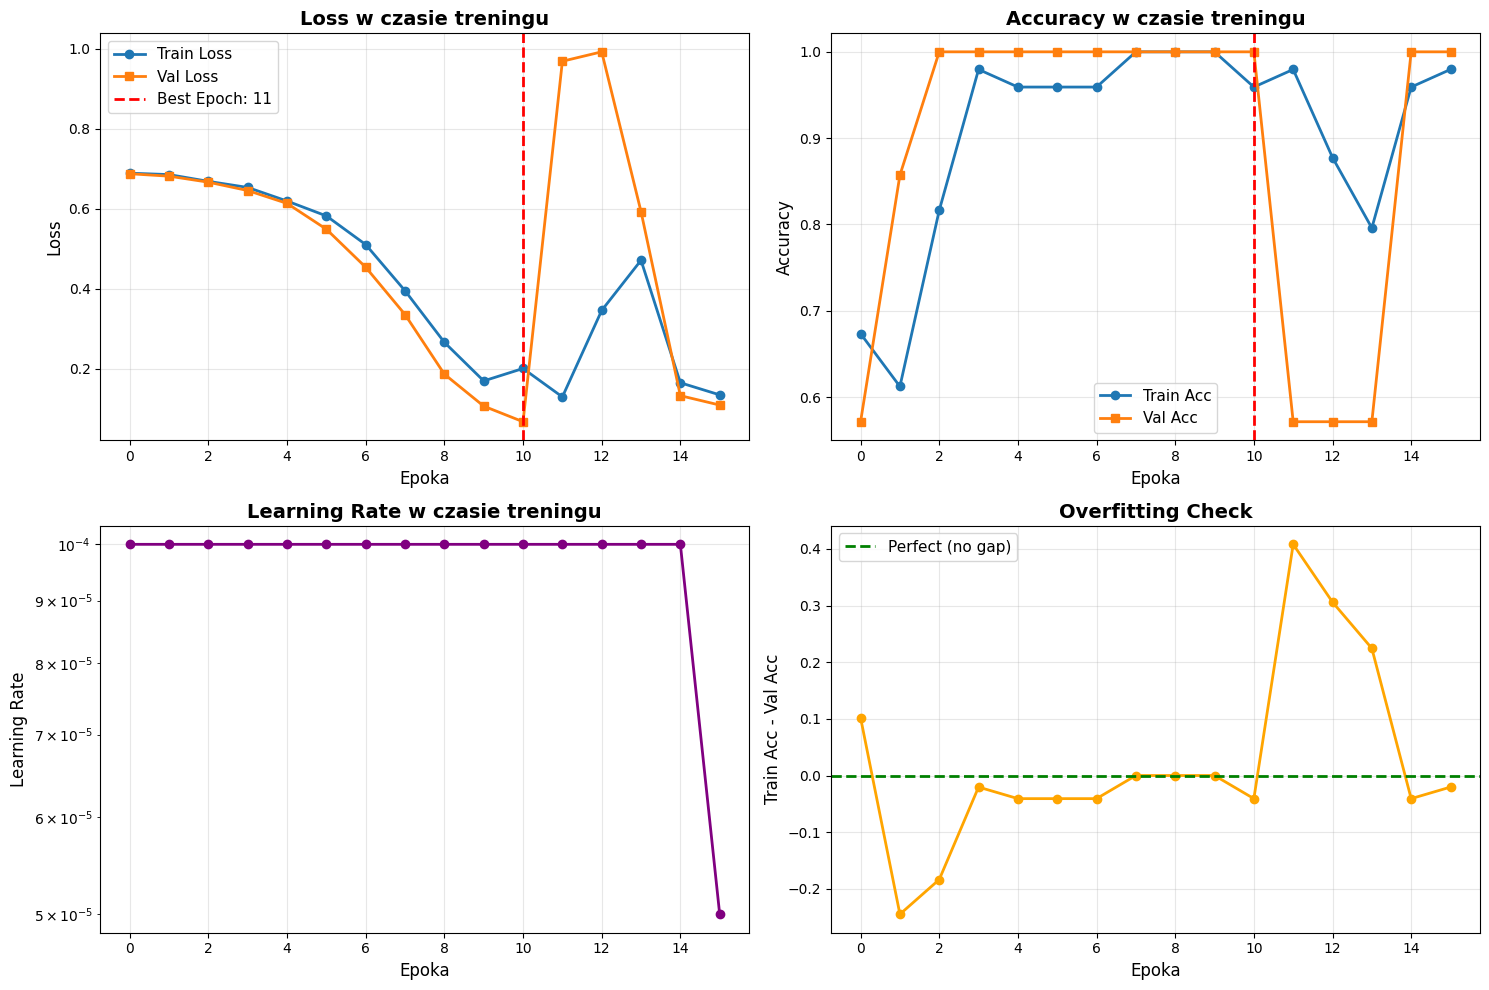

In [33]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].plot(history['train_loss'], label='Train Loss', marker='o', linewidth=2)
axes[0, 0].plot(history['val_loss'], label='Val Loss', marker='s', linewidth=2)
axes[0, 0].set_xlabel('Epoka', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].set_title('Loss w czasie treningu', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

best_epoch = history['val_loss'].index(min(history['val_loss']))
axes[0, 0].axvline(x=best_epoch, color='red', linestyle='--', 
                   label=f'Best Epoch: {best_epoch+1}', linewidth=2)
axes[0, 0].legend(fontsize=11)

axes[0, 1].plot(history['train_acc'], label='Train Acc', marker='o', linewidth=2)
axes[0, 1].plot(history['val_acc'], label='Val Acc', marker='s', linewidth=2)
axes[0, 1].set_xlabel('Epoka', fontsize=12)
axes[0, 1].set_ylabel('Accuracy', fontsize=12)
axes[0, 1].set_title('Accuracy w czasie treningu', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].axvline(x=best_epoch, color='red', linestyle='--', linewidth=2)

axes[1, 0].plot(history['lr'], marker='o', color='purple', linewidth=2)
axes[1, 0].set_xlabel('Epoka', fontsize=12)
axes[1, 0].set_ylabel('Learning Rate', fontsize=12)
axes[1, 0].set_title('Learning Rate w czasie treningu', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_yscale('log')

gap = [train - val for train, val in zip(history['train_acc'], history['val_acc'])]
axes[1, 1].plot(gap, marker='o', color='orange', linewidth=2)
axes[1, 1].axhline(y=0, color='green', linestyle='--', label='Perfect (no gap)', linewidth=2)
axes[1, 1].set_xlabel('Epoka', fontsize=12)
axes[1, 1].set_ylabel('Train Acc - Val Acc', fontsize=12)
axes[1, 1].set_title('Overfitting Check', fontsize=14, fontweight='bold')
axes[1, 1].legend(fontsize=11)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [34]:
checkpoint = torch.load('best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])

test_loss, test_acc, test_preds, test_labels = validate(
    model, test_loader, criterion, device
)

print(f"Wyniki na zbiorze testowym:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")

Wyniki na zbiorze testowym:
Test Loss: 0.0683
Test Accuracy: 1.0000 (100.00%)


In [35]:
from sklearn.metrics import classification_report, confusion_matrix

class_names = ['ADL', 'FALL']

report = classification_report(
    test_labels, 
    test_preds, 
    target_names=class_names,
    digits=4
)
print(report)

              precision    recall  f1-score   support

         ADL     1.0000    1.0000    1.0000         8
        FALL     1.0000    1.0000    1.0000         6

    accuracy                         1.0000        14
   macro avg     1.0000    1.0000    1.0000        14
weighted avg     1.0000    1.0000    1.0000        14



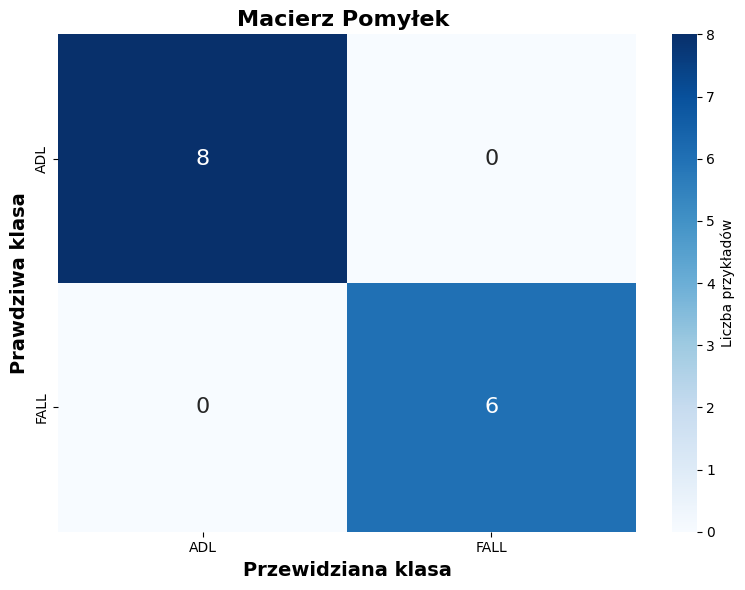

In [36]:
cm = confusion_matrix(test_labels, test_preds)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Liczba przykładów'},
            annot_kws={'size': 16})

ax.set_xlabel('Przewidziana klasa', fontsize=14, fontweight='bold')
ax.set_ylabel('Prawdziwa klasa', fontsize=14, fontweight='bold')
ax.set_title('Macierz Pomyłek ', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()